In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import vgg

In [2]:
height = 224
width = 224
channels = 3

In [3]:
input_var_0 = np.random.rand(1, height, width, channels)
input_var = tf.Variable(input_var_0, dtype=tf.float32)

with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, end_points = vgg.vgg_19(input_var, num_classes=1000, is_training=False)

In [4]:
all_variables = tf.get_collection_ref(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(all_variables[1:])

In [5]:
# TODO: construct tensors for real image and white noise 
real_image = cv2.imread('./coastal_scene.jpg')
real_image = cv2.resize(real_image, (height, width))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
real_image_batch = np.expand_dims(real_image, axis=0)
real_image_tensor = tf.constant(real_image_batch, dtype=tf.float32)

assign_real_image = tf.assign(input_var, real_image_tensor)

white_noise = np.random.rand(height, width, channels) * 255.
white_noise_batch = np.expand_dims(white_noise, axis=0)
white_noise_tensor = tf.constant(white_noise_batch, dtype=tf.float32)

assign_white_noise = tf.assign(input_var, white_noise_tensor)

INFO:tensorflow:Restoring parameters from ./vgg_19.ckpt
2995.9412
2977.4805
2959.1821
2941.0222
2923.0
2905.1128
2887.3616
2869.745
2852.2598
2834.9026
2817.669
2800.5544
2783.5554
2766.6719
2749.899
2733.2344
2716.6775
2700.226
2683.8784
2667.6318
2651.4856
2635.4395
2619.492
2603.6423
2587.8882
2572.2288
2556.6636
2541.1917
2525.812
2510.5232
2495.3254
2480.2192
2465.2031
2450.2766
2435.4382
2420.688
2406.026
2391.45
2376.9604
2362.5583
2348.2412
2334.01
2319.8635
2305.7993
2291.8193
2277.9233
2264.1082
2250.3735
2236.7217
2223.152


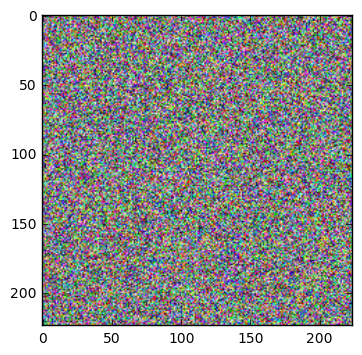

In [6]:
predictions = end_points['vgg_19/conv1/conv1_1']

batch_size_res, height_res, width_res, channels_res = np.shape(predictions)

desired_response = tf.placeholder(tf.float32, 
                                  shape=[batch_size_res, height_res, width_res, channels_res])

loss = tf.losses.mean_squared_error(desired_response, predictions)
optimizer = tf.train.AdamOptimizer(1e-3)
train_op = optimizer.minimize(loss, var_list=[input_var])

loss_summary = tf.summary.scalar('loss', loss)
image_summary = tf.summary.image('image', input_var)
merged_summary = tf.summary.merge_all()


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('./train', sess.graph)
    
    
    sess.run(init_op)
    saver.restore(sess, './vgg_19.ckpt')
    
    
    
    
    # Using the real image, get the response of the chosen layer
    assign_real_image.eval()
    input_var_ = input_var.eval()
    input_var_ = np.squeeze(input_var_, axis=0)
    cv2.imwrite('real.jpg', input_var_)
    
    desired_response_ = predictions.eval()
#     print(desired_response_)
    
    # Assign the white noise to the image
    assign_white_noise.eval()
    input_var_ = input_var.eval()
    input_var_ = np.squeeze(input_var_, axis=0)
    cv2.imwrite('white.jpg', input_var_)
    
    current_response_ = predictions.eval()
#     print(current_response_)
    
    # Begin training
    for i in range(10000):
        summary, loss_, _ = sess.run([merged_summary, loss, train_op], 
                                     feed_dict={desired_response:desired_response_})
        train_writer.add_summary(summary, i)
        if i%200==0:
            print(loss_)
    
    input_var_ = input_var.eval()
    input_var_ = np.squeeze(input_var_, axis=0)
    plt.figure()
    plt.imshow(input_var_)
    
    